https://zhuanlan.zhihu.com/p/435945714

In [1]:
import torch
from torch import nn, Tensor, optim
from torch.nn import functional as F
from torch_geometric import nn as gnn
from torch_geometric import datasets
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric import transforms as gtransforms
from torch_geometric.utils import to_networkx
import networkx as nx
from tqdm import tqdm
from plotly import express as px
from plotly import graph_objects as go
import matplotlib.pyplot as plt

In [2]:
device = "cuda:0" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
device

'cuda:0'

In [3]:
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# torch_geometric.data.Data

节点和节点之间的边构成了图。所以在 PyG 中，如果你要构建图，那么需要两个要素：节点和边。PyG 提供了torch_geometric.data.Data (下面简称Data) 用于构建图，包括 5 个属性，每一个属性都不是必须的，可以为空。

- x: 用于存储每个节点的特征，形状是 `[num_nodes, num_node_features]`
- y: 存储样本标签。如果是每个节点都有标签，那么形状是 `[num_nodes, *]`；如果是整张图只有一个标签，那么形状是 `[1, *]`
- edge_index: 用于存储节点之间的边，形状是 `[2, num_edges]`
- pos: 存储节点的坐标，形状是 `[num_nodes, num_dimensions]`
- edge_attr: 存储边的特征。形状是 `[num_edges, num_edge_features]`

In [4]:
# x: 用于存储每个节点的特征，形状是 `[num_nodes, num_node_features]`。
x = torch.tensor(
    [[2,  1],
     [5,  6],
     [3,  7],
     [12, 0]],
    dtype=torch.float
)
x

tensor([[ 2.,  1.],
        [ 5.,  6.],
        [ 3.,  7.],
        [12.,  0.]])

In [5]:
# y: 存储样本标签。如果是每个节点都有标签，那么形状是 `[num_nodes, *]`；如果是整张图只有一个标签，那么形状是 `[1, *]`。
y = torch.tensor(
    [[0],
     [2],
     [3],
     [4]],
    dtype=torch.long
)
y

tensor([[0],
        [2],
        [3],
        [4]])

In [6]:
# edge_index: 用于存储节点之间的边，形状是 `[2, num_edges]`
# 5条边: (0 -> 1), (0 -> 2), (1 -> 2), (1 -> 3), (2 -> 3)
edge_index = torch.tensor(
    [[0, 1, 0, 1, 1, 2, 3],
     [1, 0, 2, 2, 3, 3, 2]],
    dtype=torch.long
)
edge_index

tensor([[0, 1, 0, 1, 1, 2, 3],
        [1, 0, 2, 2, 3, 3, 2]])

In [7]:
data = Data(x=x, y=y, edge_index=edge_index)
data

Data(x=[4, 2], edge_index=[2, 7], y=[4, 1])

In [ ]:
for i in data:
    print(i)

('x', tensor([[ 2.,  1.],
        [ 5.,  6.],
        [ 3.,  7.],
        [12.,  0.]]))
('edge_index', tensor([[0, 1, 0, 1, 1, 2, 3],
        [1, 0, 2, 2, 3, 3, 2]]))
('y', tensor([[0],
        [2],
        [3],
        [4]]))


In [9]:
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()

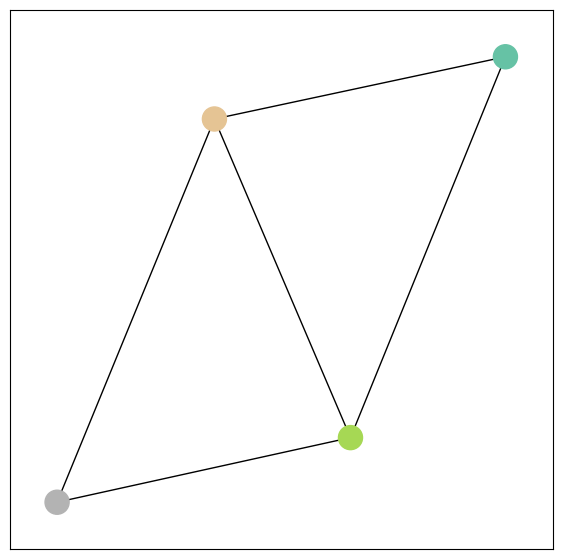

In [10]:
visualize_graph(to_networkx(data, to_undirected=True), color=data.y)

# from torch_geometric.datasets

In [11]:
transform = gtransforms.Compose([
    gtransforms.NormalizeFeatures(),
])
transform

Compose([
  NormalizeFeatures()
])

| Name          | #graphs | #nodes | #edges  | #features | #classes |
| ------------- | ------- | ------ | ------- | --------- | -------- |
| MUTAG         | 188     | ~17.9  | ~39.6   | 7         | 2        |
| ENZYMES       | 600     | ~32.6  | ~124.3  | 3         | 6        |
| PROTEINS      | 1,113   | ~39.1  | ~145.6  | 3         | 2        |
| COLLAB        | 5,000   | ~74.5  | ~4914.4 | 0         | 3        |
| IMDB-BINARY   | 1,000   | ~19.8  | ~193.1  | 0         | 2        |
| REDDIT-BINARY | 2,000   | ~429.6 | ~995.5  | 0         | 2        |

In [12]:
dataset = datasets.TUDataset(
    root="./datasets/TUDataset",
    name="ENZYMES",   # MUTAG, ENZYMES, PROTEINS, COLLAB, IMDB-BINARY, REDDIT-BINARY
    transform=transform,
    use_node_attr=True,
)
dataset[0]

Data(edge_index=[2, 168], x=[37, 21], y=[1])

In [13]:
dataset = dataset.shuffle()
dataset[0]

Data(edge_index=[2, 194], x=[46, 21], y=[1])

In [14]:
dataset.num_edge_attributes, dataset.num_edge_features, dataset.num_edge_labels

(0, 0, 0)

In [15]:
dataset.num_node_attributes, dataset.num_node_features, dataset.num_edge_labels

(18, 21, 0)

In [16]:
dataset.num_features, dataset.num_classes

(21, 6)

In [17]:
val_ratio = 0.2
dataset_len = len(dataset)
print(dataset_len)
val_dataset_len = int(dataset_len * val_ratio)
print(dataset_len - val_dataset_len)
print(val_dataset_len)

600
480
120


In [18]:
train_dataset = dataset[:-val_dataset_len]
print(len(train_dataset))
val_dataset = dataset[-val_dataset_len:]
print(len(val_dataset))

480
120


In [19]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=2, shuffle=True)
train_dataloader

In [20]:
val_dataloader = DataLoader(dataset=val_dataset, batch_size=2, shuffle=False)
val_dataloader

In [21]:
for i, batch in enumerate(train_dataloader):
    print(batch)
    print("x: \t\t",        batch.x.shape)          # [batch_sum, num_features] 图的每一条数据的长度不一定相等,batch_sum代表这个batch中的全部节点数据
    print("edge_index: \t", batch.edge_index.shape) # 代表边的连接
    print("batch: \t\t",    batch.batch.shape)      # batch代表是这个batch中哪一些数据是一组的. 0为1组,1为1组...
    # print("batch: \t\t",    batch.batch)
    print("y: \t\t",        batch.y.shape)          # 类别
    print("y: \t\t",        y)
    if i >= 5:
        break

DataBatch(edge_index=[2, 302], x=[89, 21], y=[2], batch=[89], ptr=[3])
x: 		 torch.Size([89, 21])
edge_index: 	 torch.Size([2, 302])
batch: 		 torch.Size([89])
y: 		 torch.Size([2])
y: 		 tensor([[0],
        [2],
        [3],
        [4]])
DataBatch(edge_index=[2, 152], x=[37, 21], y=[2], batch=[37], ptr=[3])
x: 		 torch.Size([37, 21])
edge_index: 	 torch.Size([2, 152])
batch: 		 torch.Size([37])
y: 		 torch.Size([2])
y: 		 tensor([[0],
        [2],
        [3],
        [4]])
DataBatch(edge_index=[2, 334], x=[84, 21], y=[2], batch=[84], ptr=[3])
x: 		 torch.Size([84, 21])
edge_index: 	 torch.Size([2, 334])
batch: 		 torch.Size([84])
y: 		 torch.Size([2])
y: 		 tensor([[0],
        [2],
        [3],
        [4]])
DataBatch(edge_index=[2, 216], x=[53, 21], y=[2], batch=[53], ptr=[3])
x: 		 torch.Size([53, 21])
edge_index: 	 torch.Size([2, 216])
batch: 		 torch.Size([53])
y: 		 torch.Size([2])
y: 		 tensor([[0],
        [2],
        [3],
        [4]])
DataBatch(edge_index=[2, 210], x=[50

In [22]:
batch.x.shape

torch.Size([52, 21])

# Model

In [23]:
class Net(nn.Module):
    def __init__(
        self,
        conv: nn.Module = gnn.GraphConv,    # [GraphConv, GCNConv, SAGEConv, GATConv]
        norm: nn.Module = nn.BatchNorm1d,   # [BatchNorm1d, LayerNorm, InstanceNorm1d]
        act: nn.Module = nn.ReLU
    ) -> None:
        super().__init__()
        self.conv1 = conv(in_channels=dataset.num_features, out_channels=64)
        self.norm1 = norm(64)
        self.act1  = act()

        self.conv2 = conv(in_channels=64, out_channels=64)
        self.norm2 = norm(64)
        self.act2  = act()

        self.conv3 = conv(in_channels=64, out_channels=64)
        self.norm3 = norm(64)
        self.act3  = act()

        self.fc    = nn.Linear(in_features=64, out_features=dataset.num_classes)

    def forward(self, x: Tensor, edge_index: Tensor, batch: Tensor = None) -> Tensor:
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = self.act1(x)

        res = x
        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = self.act2(x)
        x = x + res

        res = x
        x = self.conv3(x, edge_index)
        x = self.norm3(x)
        x = self.act3(x)
        x = x + res

        # global_max_pool: 将节点嵌入聚合到一个统一的图嵌入(readout layer)中
        x = gnn.global_max_pool(x, batch)   # [batch_sum, num_features] -> [batch, num_features]

        x = self.fc(x)
        return x

In [24]:
net = Net().to(device)
net

Net(
  (conv1): GraphConv(21, 64)
  (norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU()
  (conv2): GraphConv(64, 64)
  (norm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU()
  (fc): Linear(in_features=64, out_features=6, bias=True)
)

In [25]:
optimizer = optim.Adam(params=net.parameters())
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [26]:
epochs = 100

In [27]:
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=epochs, eta_min=optimizer.state_dict()['param_groups'][0]['lr'] * 0.01)
lr_scheduler

In [28]:
loss_fn = nn.CrossEntropyLoss()
loss_fn

CrossEntropyLoss()

# train

In [29]:
train_accuracies = []
train_lossess    = []
val_accuracies   = []
val_lossess      = []
for epoch in range(1, epochs + 1):
    net.train()
    train_y_trues = []
    train_y_preds = []
    train_losses  = []
    pbar = tqdm(total=len(train_dataloader), desc=f"train-epoch: {epoch}")
    for batch in train_dataloader:
        optimizer.zero_grad()
        x, edge_index, batch, y = batch.x, batch.edge_index, batch.batch, batch.y
        x, edge_index, batch, y = x.to(device), edge_index.to(device), batch.to(device), y.to(device)
        y_pred = net(x, edge_index, batch)
        loss: Tensor = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()

        train_y_trues.append(y)
        train_y_preds.append(y_pred.argmax(dim=-1))
        train_losses.append(loss.item())
        pbar.update(1)
        pbar.set_postfix({"loss": loss.item()})
    pbar.close()

    lr_scheduler.step()

    # 准确率
    train_y_trues_ = torch.cat(train_y_trues)
    train_y_preds_ = torch.cat(train_y_preds)
    train_accuracy = (train_y_trues_ == train_y_preds_).float().sum().divide(len(train_y_trues_))
    train_accuracies.append(train_accuracy.item())
    train_lossess.append(torch.tensor(train_losses).mean().item())


    net.eval()
    val_y_trues = []
    val_y_preds = []
    val_losses  = []
    pbar = tqdm(total=len(val_dataloader), desc=f"val-epoch: {epoch}")
    for batch in val_dataloader:
        x, edge_index, batch, y = batch.x, batch.edge_index, batch.batch, batch.y
        x, edge_index, batch, y = x.to(device), edge_index.to(device), batch.to(device), y.to(device)
        with torch.inference_mode():
            y_pred = net(x, edge_index, batch)
        loss: Tensor = loss_fn(y_pred, y)

        val_y_trues.append(y)
        val_y_preds.append(y_pred.argmax(dim=-1))
        val_losses.append(loss.item())
        pbar.update(1)
        pbar.set_postfix({"loss": loss.item()})
    pbar.close()

    # 准确率
    val_y_trues_ = torch.cat(val_y_trues)
    val_y_preds_ = torch.cat(val_y_preds)
    val_accuracy = (val_y_trues_ == val_y_preds_).float().sum().divide(len(val_y_trues_))
    val_accuracies.append(val_accuracy.item())
    val_lossess.append(torch.tensor(val_losses).mean().item())

    print(f"\033[0;31;40mepoch: {epoch}\033[0m " +
        f"\033[0;32;40mtrain_accuracy = {train_accuracy.item()}\033[0m " +
        f"\033[0;34;40mval_accuracy = {val_accuracy.item()}\033[0m")

val-epoch: 1: 100%|██████████| 60/60 [00:02<00:00, 27.65it/s, loss=2.5] 


epoch: 1 train_accuracy = 0.1979166716337204 val_accuracy = 0.24166667461395264


val-epoch: 2: 100%|██████████| 60/60 [00:02<00:00, 26.81it/s, loss=1.96] 


epoch: 2 train_accuracy = 0.2958333492279053 val_accuracy = 0.20000001788139343


val-epoch: 3: 100%|██████████| 60/60 [00:02<00:00, 27.46it/s, loss=1.9]  


epoch: 3 train_accuracy = 0.30416667461395264 val_accuracy = 0.24166667461395264


val-epoch: 4: 100%|██████████| 60/60 [00:02<00:00, 29.18it/s, loss=2.18] 


epoch: 4 train_accuracy = 0.37291669845581055 val_accuracy = 0.31666669249534607


val-epoch: 5: 100%|██████████| 60/60 [00:02<00:00, 24.53it/s, loss=2.12] 


epoch: 5 train_accuracy = 0.3708333671092987 val_accuracy = 0.23333334922790527


val-epoch: 6: 100%|██████████| 60/60 [00:02<00:00, 24.69it/s, loss=1.81] 


epoch: 6 train_accuracy = 0.42916667461395264 val_accuracy = 0.2750000059604645


val-epoch: 7: 100%|██████████| 60/60 [00:02<00:00, 25.31it/s, loss=2.02] 


epoch: 7 train_accuracy = 0.4208333492279053 val_accuracy = 0.25


val-epoch: 8: 100%|██████████| 60/60 [00:02<00:00, 26.66it/s, loss=1.97] 


epoch: 8 train_accuracy = 0.4583333432674408 val_accuracy = 0.22500000894069672


val-epoch: 9: 100%|██████████| 60/60 [00:01<00:00, 30.01it/s, loss=1.81]  


epoch: 9 train_accuracy = 0.4541666805744171 val_accuracy = 0.40000003576278687


val-epoch: 10: 100%|██████████| 60/60 [00:02<00:00, 25.70it/s, loss=2.02] 


epoch: 10 train_accuracy = 0.48125001788139343 val_accuracy = 0.40833336114883423


val-epoch: 11: 100%|██████████| 60/60 [00:02<00:00, 26.22it/s, loss=2.16]  


epoch: 11 train_accuracy = 0.5166667103767395 val_accuracy = 0.3333333432674408


val-epoch: 12: 100%|██████████| 60/60 [00:02<00:00, 28.18it/s, loss=1.73] 


epoch: 12 train_accuracy = 0.5145833492279053 val_accuracy = 0.2666666805744171


val-epoch: 13: 100%|██████████| 60/60 [00:02<00:00, 24.57it/s, loss=1.25] 


epoch: 13 train_accuracy = 0.5604166984558105 val_accuracy = 0.4166666865348816


val-epoch: 14: 100%|██████████| 60/60 [00:02<00:00, 25.62it/s, loss=1.31]  


epoch: 14 train_accuracy = 0.5687500238418579 val_accuracy = 0.3750000298023224


val-epoch: 15: 100%|██████████| 60/60 [00:02<00:00, 27.47it/s, loss=1.04] 


epoch: 15 train_accuracy = 0.5833333730697632 val_accuracy = 0.3750000298023224


val-epoch: 16: 100%|██████████| 60/60 [00:02<00:00, 25.84it/s, loss=1.1]  


epoch: 16 train_accuracy = 0.6395833492279053 val_accuracy = 0.2750000059604645


val-epoch: 17: 100%|██████████| 60/60 [00:02<00:00, 24.63it/s, loss=1.25] 


epoch: 17 train_accuracy = 0.6458333730697632 val_accuracy = 0.30000001192092896


val-epoch: 18: 100%|██████████| 60/60 [00:02<00:00, 26.08it/s, loss=1.66] 


epoch: 18 train_accuracy = 0.6625000238418579 val_accuracy = 0.24166667461395264


val-epoch: 19: 100%|██████████| 60/60 [00:02<00:00, 26.94it/s, loss=1.07] 


epoch: 19 train_accuracy = 0.6354166865348816 val_accuracy = 0.36666667461395264


val-epoch: 20: 100%|██████████| 60/60 [00:02<00:00, 25.22it/s, loss=1.69] 


epoch: 20 train_accuracy = 0.6812500357627869 val_accuracy = 0.20000001788139343


val-epoch: 21: 100%|██████████| 60/60 [00:02<00:00, 26.44it/s, loss=1.25]  


epoch: 21 train_accuracy = 0.6895833611488342 val_accuracy = 0.44166669249534607


val-epoch: 22: 100%|██████████| 60/60 [00:02<00:00, 24.86it/s, loss=0.681] 


epoch: 22 train_accuracy = 0.6979166865348816 val_accuracy = 0.42500001192092896


val-epoch: 23: 100%|██████████| 60/60 [00:02<00:00, 25.33it/s, loss=0.775]


epoch: 23 train_accuracy = 0.7083333730697632 val_accuracy = 0.3500000238418579


val-epoch: 24: 100%|██████████| 60/60 [00:02<00:00, 24.28it/s, loss=0.981]


epoch: 24 train_accuracy = 0.7458333969116211 val_accuracy = 0.3750000298023224


val-epoch: 25: 100%|██████████| 60/60 [00:02<00:00, 25.48it/s, loss=1.22] 


epoch: 25 train_accuracy = 0.7541667222976685 val_accuracy = 0.3333333432674408


val-epoch: 26: 100%|██████████| 60/60 [00:02<00:00, 24.23it/s, loss=1.67]  


epoch: 26 train_accuracy = 0.8083333969116211 val_accuracy = 0.38333335518836975


val-epoch: 27: 100%|██████████| 60/60 [00:02<00:00, 26.18it/s, loss=1.23] 


epoch: 27 train_accuracy = 0.7854167222976685 val_accuracy = 0.32500001788139343


val-epoch: 28: 100%|██████████| 60/60 [00:02<00:00, 27.76it/s, loss=1.08] 


epoch: 28 train_accuracy = 0.8041667342185974 val_accuracy = 0.491666704416275


val-epoch: 29: 100%|██████████| 60/60 [00:02<00:00, 26.72it/s, loss=1.03] 


epoch: 29 train_accuracy = 0.8166667222976685 val_accuracy = 0.46666669845581055


val-epoch: 30: 100%|██████████| 60/60 [00:02<00:00, 24.58it/s, loss=1.67] 


epoch: 30 train_accuracy = 0.7979167103767395 val_accuracy = 0.46666669845581055


val-epoch: 31: 100%|██████████| 60/60 [00:02<00:00, 26.65it/s, loss=0.496]


epoch: 31 train_accuracy = 0.8083333969116211 val_accuracy = 0.45000001788139343


val-epoch: 32: 100%|██████████| 60/60 [00:02<00:00, 24.84it/s, loss=0.684]


epoch: 32 train_accuracy = 0.7979167103767395 val_accuracy = 0.42500001192092896


val-epoch: 33: 100%|██████████| 60/60 [00:02<00:00, 26.23it/s, loss=1.19] 


epoch: 33 train_accuracy = 0.8750000596046448 val_accuracy = 0.40000003576278687


val-epoch: 34: 100%|██████████| 60/60 [00:02<00:00, 25.77it/s, loss=0.864] 


epoch: 34 train_accuracy = 0.8458333611488342 val_accuracy = 0.46666669845581055


val-epoch: 35: 100%|██████████| 60/60 [00:02<00:00, 24.90it/s, loss=0.727]


epoch: 35 train_accuracy = 0.8604167103767395 val_accuracy = 0.550000011920929


val-epoch: 36: 100%|██████████| 60/60 [00:02<00:00, 27.53it/s, loss=0.942] 


epoch: 36 train_accuracy = 0.8437500596046448 val_accuracy = 0.4833333492279053


val-epoch: 37: 100%|██████████| 60/60 [00:02<00:00, 26.42it/s, loss=1.73]  


epoch: 37 train_accuracy = 0.9020833969116211 val_accuracy = 0.45000001788139343


val-epoch: 38: 100%|██████████| 60/60 [00:02<00:00, 25.05it/s, loss=1.34]  


epoch: 38 train_accuracy = 0.8583333492279053 val_accuracy = 0.42500001192092896


val-epoch: 39: 100%|██████████| 60/60 [00:02<00:00, 26.52it/s, loss=0.918]


epoch: 39 train_accuracy = 0.8791667222976685 val_accuracy = 0.4583333432674408


val-epoch: 40: 100%|██████████| 60/60 [00:02<00:00, 26.93it/s, loss=0.389] 


epoch: 40 train_accuracy = 0.9125000238418579 val_accuracy = 0.5166667103767395


val-epoch: 41: 100%|██████████| 60/60 [00:02<00:00, 26.27it/s, loss=1.26]  


epoch: 41 train_accuracy = 0.88958340883255 val_accuracy = 0.4750000238418579


val-epoch: 42: 100%|██████████| 60/60 [00:02<00:00, 25.90it/s, loss=0.825]


epoch: 42 train_accuracy = 0.9083333611488342 val_accuracy = 0.38333335518836975


val-epoch: 43: 100%|██████████| 60/60 [00:02<00:00, 25.50it/s, loss=1.32]  


epoch: 43 train_accuracy = 0.9229167103767395 val_accuracy = 0.40833336114883423


val-epoch: 44: 100%|██████████| 60/60 [00:02<00:00, 26.62it/s, loss=1.09] 


epoch: 44 train_accuracy = 0.9145833849906921 val_accuracy = 0.42500001192092896


val-epoch: 45: 100%|██████████| 60/60 [00:02<00:00, 25.25it/s, loss=0.949]


epoch: 45 train_accuracy = 0.9354166984558105 val_accuracy = 0.4833333492279053


val-epoch: 46: 100%|██████████| 60/60 [00:02<00:00, 25.94it/s, loss=1.12] 


epoch: 46 train_accuracy = 0.9104167222976685 val_accuracy = 0.3916666805744171


val-epoch: 47: 100%|██████████| 60/60 [00:02<00:00, 26.04it/s, loss=0.529] 


epoch: 47 train_accuracy = 0.9395833611488342 val_accuracy = 0.5666667222976685


val-epoch: 48: 100%|██████████| 60/60 [00:02<00:00, 28.13it/s, loss=1.12]  


epoch: 48 train_accuracy = 0.9291667342185974 val_accuracy = 0.5250000357627869


val-epoch: 49: 100%|██████████| 60/60 [00:02<00:00, 27.66it/s, loss=0.485] 


epoch: 49 train_accuracy = 0.9270833730697632 val_accuracy = 0.5


val-epoch: 50: 100%|██████████| 60/60 [00:02<00:00, 25.21it/s, loss=0.437] 


epoch: 50 train_accuracy = 0.9354166984558105 val_accuracy = 0.5333333611488342


val-epoch: 51: 100%|██████████| 60/60 [00:02<00:00, 28.32it/s, loss=0.707] 


epoch: 51 train_accuracy = 0.9291667342185974 val_accuracy = 0.5166667103767395


val-epoch: 52: 100%|██████████| 60/60 [00:02<00:00, 28.39it/s, loss=0.561]


epoch: 52 train_accuracy = 0.9479166865348816 val_accuracy = 0.45000001788139343


val-epoch: 53: 100%|██████████| 60/60 [00:02<00:00, 25.49it/s, loss=0.914] 


epoch: 53 train_accuracy = 0.9333333969116211 val_accuracy = 0.5


val-epoch: 54: 100%|██████████| 60/60 [00:02<00:00, 27.07it/s, loss=1.46]  


epoch: 54 train_accuracy = 0.9541667103767395 val_accuracy = 0.4750000238418579


val-epoch: 55: 100%|██████████| 60/60 [00:02<00:00, 27.33it/s, loss=1.06]  


epoch: 55 train_accuracy = 0.9479166865348816 val_accuracy = 0.5


val-epoch: 56: 100%|██████████| 60/60 [00:02<00:00, 24.92it/s, loss=0.478]


epoch: 56 train_accuracy = 0.9395833611488342 val_accuracy = 0.46666669845581055


val-epoch: 57: 100%|██████████| 60/60 [00:02<00:00, 26.09it/s, loss=0.708] 


epoch: 57 train_accuracy = 0.9437500238418579 val_accuracy = 0.4583333432674408


val-epoch: 58: 100%|██████████| 60/60 [00:02<00:00, 26.19it/s, loss=0.341]


epoch: 58 train_accuracy = 0.95208340883255 val_accuracy = 0.5166667103767395


val-epoch: 59: 100%|██████████| 60/60 [00:02<00:00, 27.73it/s, loss=0.793] 


epoch: 59 train_accuracy = 0.9687500596046448 val_accuracy = 0.5166667103767395


val-epoch: 60: 100%|██████████| 60/60 [00:02<00:00, 24.58it/s, loss=0.466] 


epoch: 60 train_accuracy = 0.9666666984558105 val_accuracy = 0.550000011920929


val-epoch: 61: 100%|██████████| 60/60 [00:02<00:00, 25.01it/s, loss=0.132] 


epoch: 61 train_accuracy = 0.9604167342185974 val_accuracy = 0.5333333611488342


val-epoch: 62: 100%|██████████| 60/60 [00:02<00:00, 26.22it/s, loss=0.715] 


epoch: 62 train_accuracy = 0.9666666984558105 val_accuracy = 0.5250000357627869


val-epoch: 63: 100%|██████████| 60/60 [00:02<00:00, 26.12it/s, loss=0.906] 


epoch: 63 train_accuracy = 0.9604167342185974 val_accuracy = 0.5333333611488342


val-epoch: 64: 100%|██████████| 60/60 [00:02<00:00, 24.63it/s, loss=1.27]  


epoch: 64 train_accuracy = 0.9729167222976685 val_accuracy = 0.5166667103767395


val-epoch: 65: 100%|██████████| 60/60 [00:02<00:00, 27.48it/s, loss=0.517]


epoch: 65 train_accuracy = 0.9541667103767395 val_accuracy = 0.5083333849906921


val-epoch: 66: 100%|██████████| 60/60 [00:02<00:00, 27.30it/s, loss=0.791] 


epoch: 66 train_accuracy = 0.9645833969116211 val_accuracy = 0.5416666865348816


val-epoch: 67: 100%|██████████| 60/60 [00:02<00:00, 27.58it/s, loss=1.57]  


epoch: 67 train_accuracy = 0.9687500596046448 val_accuracy = 0.5250000357627869


val-epoch: 68: 100%|██████████| 60/60 [00:02<00:00, 24.94it/s, loss=1.03] 


epoch: 68 train_accuracy = 0.9750000238418579 val_accuracy = 0.4833333492279053


val-epoch: 69: 100%|██████████| 60/60 [00:02<00:00, 24.81it/s, loss=1.16]  


epoch: 69 train_accuracy = 0.98333340883255 val_accuracy = 0.5416666865348816


val-epoch: 70: 100%|██████████| 60/60 [00:02<00:00, 26.48it/s, loss=0.414]


epoch: 70 train_accuracy = 0.98333340883255 val_accuracy = 0.5750000476837158


val-epoch: 71: 100%|██████████| 60/60 [00:02<00:00, 26.59it/s, loss=0.705] 


epoch: 71 train_accuracy = 0.9791667461395264 val_accuracy = 0.5250000357627869


val-epoch: 72: 100%|██████████| 60/60 [00:02<00:00, 26.50it/s, loss=0.83]  


epoch: 72 train_accuracy = 0.98333340883255 val_accuracy = 0.5750000476837158


val-epoch: 73: 100%|██████████| 60/60 [00:02<00:00, 24.54it/s, loss=0.964] 


epoch: 73 train_accuracy = 0.9770833849906921 val_accuracy = 0.491666704416275


val-epoch: 74: 100%|██████████| 60/60 [00:02<00:00, 26.10it/s, loss=1.08] 


epoch: 74 train_accuracy = 0.98333340883255 val_accuracy = 0.4833333492279053


val-epoch: 75: 100%|██████████| 60/60 [00:02<00:00, 24.45it/s, loss=0.637]


epoch: 75 train_accuracy = 0.9791667461395264 val_accuracy = 0.4833333492279053


val-epoch: 76: 100%|██████████| 60/60 [00:02<00:00, 24.27it/s, loss=1.68]  


epoch: 76 train_accuracy = 0.9729167222976685 val_accuracy = 0.5166667103767395


val-epoch: 77: 100%|██████████| 60/60 [00:02<00:00, 24.82it/s, loss=1.51]  


epoch: 77 train_accuracy = 0.9791667461395264 val_accuracy = 0.5333333611488342


val-epoch: 78: 100%|██████████| 60/60 [00:02<00:00, 25.09it/s, loss=0.649] 


epoch: 78 train_accuracy = 0.9875000715255737 val_accuracy = 0.5250000357627869


val-epoch: 79: 100%|██████████| 60/60 [00:02<00:00, 26.71it/s, loss=1.23]  


epoch: 79 train_accuracy = 0.9854167103767395 val_accuracy = 0.5250000357627869


val-epoch: 80: 100%|██████████| 60/60 [00:02<00:00, 26.15it/s, loss=1.63]  


epoch: 80 train_accuracy = 0.9854167103767395 val_accuracy = 0.491666704416275


val-epoch: 81: 100%|██████████| 60/60 [00:01<00:00, 30.68it/s, loss=1.5]   


epoch: 81 train_accuracy = 0.9812500476837158 val_accuracy = 0.5333333611488342


val-epoch: 82: 100%|██████████| 60/60 [00:02<00:00, 26.29it/s, loss=1.05]  


epoch: 82 train_accuracy = 0.9812500476837158 val_accuracy = 0.5833333730697632


val-epoch: 83: 100%|██████████| 60/60 [00:02<00:00, 26.83it/s, loss=1.28] 


epoch: 83 train_accuracy = 0.98333340883255 val_accuracy = 0.5416666865348816


val-epoch: 84: 100%|██████████| 60/60 [00:02<00:00, 26.44it/s, loss=1.36]  


epoch: 84 train_accuracy = 0.9812500476837158 val_accuracy = 0.5416666865348816


val-epoch: 85: 100%|██████████| 60/60 [00:02<00:00, 23.91it/s, loss=1.31]  


epoch: 85 train_accuracy = 0.9812500476837158 val_accuracy = 0.5166667103767395


val-epoch: 86: 100%|██████████| 60/60 [00:02<00:00, 26.33it/s, loss=1.84]  


epoch: 86 train_accuracy = 0.9791667461395264 val_accuracy = 0.550000011920929


val-epoch: 87: 100%|██████████| 60/60 [00:02<00:00, 26.01it/s, loss=2.21]  


epoch: 87 train_accuracy = 0.9854167103767395 val_accuracy = 0.5416666865348816


val-epoch: 88: 100%|██████████| 60/60 [00:02<00:00, 26.47it/s, loss=1.05]  


epoch: 88 train_accuracy = 0.9791667461395264 val_accuracy = 0.5333333611488342


val-epoch: 89: 100%|██████████| 60/60 [00:02<00:00, 25.03it/s, loss=1.35]  


epoch: 89 train_accuracy = 0.9916667342185974 val_accuracy = 0.5416666865348816


val-epoch: 90: 100%|██████████| 60/60 [00:02<00:00, 27.13it/s, loss=1.44]  


epoch: 90 train_accuracy = 0.9875000715255737 val_accuracy = 0.5750000476837158


val-epoch: 91: 100%|██████████| 60/60 [00:00<00:00, 300.00it/s, loss=1.24]  


epoch: 91 train_accuracy = 0.9812500476837158 val_accuracy = 0.5583333373069763


val-epoch: 92: 100%|██████████| 60/60 [00:00<00:00, 299.11it/s, loss=1.37]  


epoch: 92 train_accuracy = 0.98333340883255 val_accuracy = 0.5750000476837158


val-epoch: 93: 100%|██████████| 60/60 [00:00<00:00, 201.34it/s, loss=1.3]   


epoch: 93 train_accuracy = 0.98333340883255 val_accuracy = 0.5666667222976685


val-epoch: 94: 100%|██████████| 60/60 [00:00<00:00, 233.46it/s, loss=1.72]  


epoch: 94 train_accuracy = 0.9916667342185974 val_accuracy = 0.5583333373069763


val-epoch: 95: 100%|██████████| 60/60 [00:00<00:00, 190.64it/s, loss=1.94]  


epoch: 95 train_accuracy = 0.9812500476837158 val_accuracy = 0.550000011920929


val-epoch: 96: 100%|██████████| 60/60 [00:00<00:00, 235.71it/s, loss=1.97]  


epoch: 96 train_accuracy = 0.9895833730697632 val_accuracy = 0.550000011920929


val-epoch: 97: 100%|██████████| 60/60 [00:00<00:00, 241.94it/s, loss=1.41]  


epoch: 97 train_accuracy = 0.9875000715255737 val_accuracy = 0.5250000357627869


val-epoch: 98: 100%|██████████| 60/60 [00:00<00:00, 267.86it/s, loss=1.88]  


epoch: 98 train_accuracy = 0.9875000715255737 val_accuracy = 0.550000011920929


val-epoch: 99: 100%|██████████| 60/60 [00:00<00:00, 297.67it/s, loss=1.52]  


epoch: 99 train_accuracy = 0.9812500476837158 val_accuracy = 0.5416666865348816


val-epoch: 100: 100%|██████████| 60/60 [00:00<00:00, 322.58it/s, loss=1.43]  

epoch: 100 train_accuracy = 0.9854167103767395 val_accuracy = 0.5416666865348816


In [30]:
print(max(train_accuracies), max(val_accuracies))
# 0.9867549538612366 0.8378378748893738

0.9916667342185974 0.5833333730697632


In [31]:
figure = go.Figure(
    data=[
        go.Scatter(
            y=train_accuracies,
            mode="lines+markers",
            name="train",
        ),
        go.Scatter(
            y=val_accuracies,
            mode="lines+markers",
            name="val",
        ),
    ]
)
figure.show()

In [32]:
figure = go.Figure(
    data=[
        go.Scatter(
            y=train_lossess,
            mode="lines+markers",
            name="train",
        ),
        go.Scatter(
            y=val_lossess,
            mode="lines+markers",
            name="val",
        ),
    ]
)
figure.show()